[  1.11641954 -37.70855175]
[  0.66802836 -35.55425672]
[  2.35996153 -37.62381839]
[  3.20808451 -29.93974701]


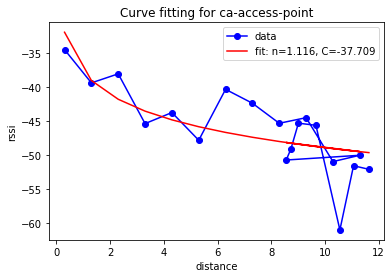

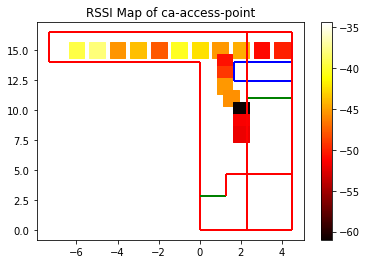

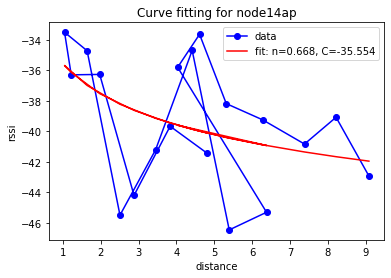

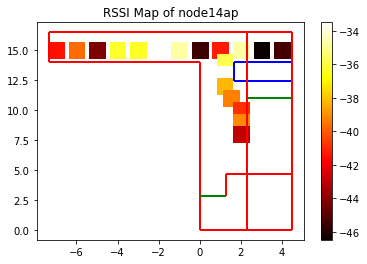

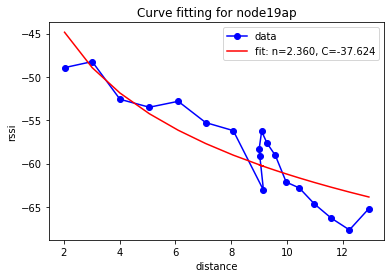

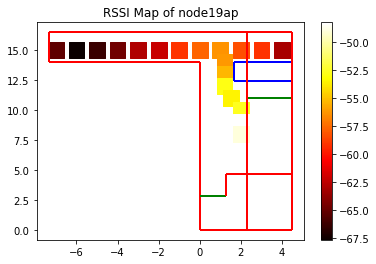

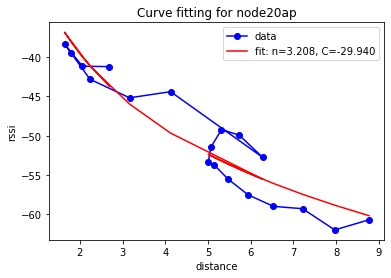

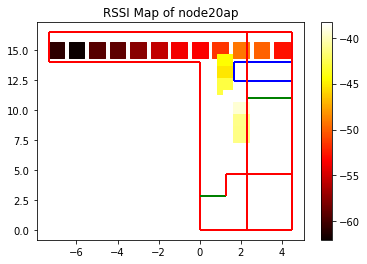

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import pprint
from positions import Positions
import netmode
from scipy.optimize import curve_fit
from math import sqrt

%matplotlib inline

Node_coords = {'ca-access-point':(-7.3,15), 
               'node14ap':(-2.3,16),
               'node19ap':(2.3,6),
               'node20ap':(0.2,10),
}

dataset = pd.read_csv("positions.csv",header = [0,1,2])
features = np.asarray(dataset.iloc[:,3:])
labels = np.asarray(dataset["Relative Position"])
headers = list(dataset)

labels = labels.flatten() # all labels in an array
points = list(set(labels)) # unique labels
x = [Positions[str(point)]['Position_X'] for point in points]
y = [Positions[str(point)]['Position_Y'] for point in points] 

def return_mean(network_rssi):
    sums = {}
    counts = {}
    i = 0
    for label in labels:
        if network_rssi[i] != 100:
            if label not in sums:
                sums[label] = network_rssi[i]
                counts[label] = 1
            else:
                sums[label] += network_rssi[i]
                counts[label] += 1
        i += 1

    for label in counts:
        sums[label] /= counts[label]

    for point in points:
        if point not in sums:
            sums[point] = -100

    return [sums[point] for point in points]

def func(d, n, C):
    #return a * np.exp(-b * x) + c
    return -10*n*np.log10(d) + C 

# (name of network, array with mean rssi values by point)
def find_optimal_curve_and_plot(network,network_mean_rssi):
    # node10ap distances by point
    x1 = Node_coords[network][0]
    y1 = Node_coords[network][1]
    distances = [sqrt((x2-x1)**2 + (y2-y1)**2) for (x2,y2) in zip(x,y)]

    # popt, pcov = curve_fit(func, xdata, ydata)
    popt, pcov = curve_fit(func, distances, network_mean_rssi)
    # Constrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5
    # popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
    #popt, pcov = curve_fit(func, distances, network_mean_rssi, bounds=([2.,-100], [3., 100.]))
    print(popt)
    plt.figure()
    plt.plot(distances, network_mean_rssi, 'bo-', label='data')
    plt.plot(distances, func(distances, *popt), 'r-',
             label='fit: n=%5.3f, C=%5.3f' % tuple(popt))
    plt.title('Curve fitting for {}'.format(network))
    plt.xlabel('distance')
    plt.ylabel('rssi')
    plt.legend()
    #plt.show()
    plt.draw()
    #plt.waitforbuttonpress(0) # this will wait for indefinite time
    #plt.close()

def plot_heatmap(network,network_mean_rssi):
    #plt.ion()
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    netmode.plot_ergasthrio(ax)
    #cm = plt.cm.get_cmap('RdYlBu')
    cm = plt.cm.get_cmap('hot')
    my_cmap = cm(np.linspace(0,1,len(network_mean_rssi)))
    rects = []
    simple_plot = True
    if simple_plot:
        sc = plt.scatter(x,y,c=network_mean_rssi,s=250,marker='s',cmap=cm)
        plt.colorbar(sc)
        #sc.remove()
    else: #better plot but freaking messy
        for i in range(len(x)):
            if i<=13:
                rect = Rectangle((x[i] - 0.5, y[i] - 1), 1, 2.5, color=my_cmap[i])
            else:
                rect = Rectangle((x[i] - 0.5, y[i] - 0.5), 1, 1, color=my_cmap[i])
            rects.append(rect)
            ax.add_patch(rect)
        minx = min(network_mean_rssi)
        maxx = max(network_mean_rssi)
        N =  len(network_mean_rssi)
        norm = mpl.colors.Normalize(vmin=minx,vmax=maxx)
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm)#, ticks=np.linspace(minx,maxx,N), boundaries=np.arange(minx-0.05,maxx+0.1,.1))
        #for i in rects: i.remove()
    plt.title('RSSI Map of {}'.format(network))
    #plt.show()
    plt.draw()
    # plt.waitforbuttonpress(0) # this will wait for indefinite time
    #plt.close(fig)

plot = True
if plot:
    networks = [network for network in Node_coords]
    #network = networks[1] #'ca-access-point'
    for network in networks:
        # network rssi values
        network_rssi = np.asarray(dataset[network]).flatten()
        # network rssi mean value by point in order of points
        network_rssi_mean = return_mean(network_rssi) 

        find_optimal_curve_and_plot(network, network_rssi_mean)
        plot_heatmap(network, network_rssi_mean)

create_mean_csv = True
if create_mean_csv:
    mean_csv = {}
    
    first = [i for i in headers if 'Relative Position' in i][0] # relative header
    second = [i for i in headers if 'Position X' in i][0] # relative header
    third = [i for i in headers if 'Position Y' in i][0] # relative header
    mean_csv[first] = points
    mean_csv[second] = x
    mean_csv[third] = y

    for network in Node_coords:
        head = [i for i in headers if network in i][0] # relative header
        # network rssi values
        network_rssi = np.asarray(dataset[network]).flatten()
        # network rssi mean value by point in order of points
        network_rssi_mean = return_mean(network_rssi)
        mean_csv[head] = network_rssi_mean
    
    df = pd.DataFrame(mean_csv)
    df.to_csv('mean_positions.csv', na_rep = '100', index = False)